# Build a simple Neural Network

In this project, we will build a simple neural network from scratch using Numpy:
 library

 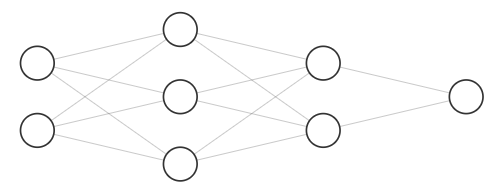

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# First I will code some class

## Activation Functions Class

**In this project, we only support some activation function below:**

* sigmoid
* tanh
* sign

In [2]:
class ActivationFunction:
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def tanh(z):
        return np.tanh(z)

    @staticmethod
    def sign(z):
        return np.sign(z)

    def sigmoid_derivative(self, da, z):
        sig = self.sigmoid(z)
        return da * sig * (1 - sig)

    def tanh_derivative(self, da, z):
        tanh = self.tanh(z)
        return da*(1-tanh**2)

    @staticmethod
    def sign_derivative(self, da, z):
        return np.zeros(z.shape[0], da.shape[0])

## Sequential Class

Because we build a ANN, so we only support Dense layers.

In [3]:
class Sequential:
    def __init__(self):
        self.nn_architecture = []
        # Feed Forward
        self.w = []
        self.b = []
        self.a = []
        self.z = []
        self.L = 0
        self.input_shape = 0
        # Back Propagation
        self.dw = []
        self.db = []
        self.da = []
        self.dz = []

    def _init_layer(self, shape1: int, shape2: int):
        """
        Init layers parameters when you add new layer.
        :param shape1: int
            Number of neural unit of new layer.
        :param shape2: int
            Number of neural unit of latest layer.
        :return:
        """
        np.random.seed(3010)
        # Feed Forward
        self.w.append(np.random.rand(shape1, shape2)*0.1)
        self.b.append(np.zeros((1, shape1)))
        self.a.append(np.zeros((1, shape1)))
        self.z.append(np.zeros((1, shape1)))

        # Back propagation
        self.dw.append(np.zeros((shape1, shape2)))
        self.db.append(np.zeros((1, shape1)))
        self.da.append(np.zeros((1, shape1)))
        self.dz.append(np.zeros((1, shape1)))

    def add(self, layer_name: str, n_unit: int, activation: str = None):
        """
        Add new layer to your neural network.
        :param layer_name: str
            Name of your layers.
            In this project we only support "input", "dense", "output" layers.
        :param n_unit: int
            Number of neural unit of new layer
        :param activation: str
            Activation function that you want in this layer.
            In this project we only support "sigmoid", "tanh", "sign" functions.
        :return:
        """
        full_layer_name = str(self.L) + '_' + layer_name + '_' + str(n_unit) + '_' + str(activation)
        self.nn_architecture.append((full_layer_name, activation))
        if layer_name == 'input':
            self.input_shape = n_unit
            self._init_layer(0, 0)
        elif self.L == 1:
            self._init_layer(n_unit, self.input_shape)
        else:
            self._init_layer(n_unit, self.w[self.L - 1].shape[0])
        self.L += 1
        print("-> added layer", full_layer_name)

    def _forward_propagation(self, x_train: np.ndarray) -> np.ndarray:
        """
        Feed forward phase when training model.
        :param x_train: np.ndarray
            Input of your training set.
        :return: np.ndarray
            Your y_hat output
        """
        self.a[0] = x_train
        for l in range(1, self.L):
            activation = self.nn_architecture[l][1]
            if activation == 'sigmoid':
                activation_function = ActivationFunction().sigmoid
            elif activation == 'tanh':
                activation_function = ActivationFunction().tanh
            elif activation == 'sign':
                activation_function = ActivationFunction().sign
            else:
                raise Exception(f"We don't support {activation} function")

            self.z[l] = self.a[l - 1] @ self.w[l].T + self.b[l]
            self.a[l] = activation_function(self.z[l])
        return self.a[self.L - 1]

    def _back_propagation(self, y_train: np.ndarray, y_hat: np.ndarray):
        """
        Back propagation phase when training model.
        :param y_train: np.ndarray
            Labels of your training set.
        :param y_hat: np.ndarray
            y_hat of feedforward phase
        :return: None
        """
        m = y_train.shape[0]
        self.da[self.L-1] = -(np.divide(y_train, y_hat) - np.divide(1 - y_train, 1 - y_hat))
        for l in reversed(range(1, self.L)):
            activation = self.nn_architecture[l][1]
            if activation == 'sigmoid':
                activation_derivative = ActivationFunction().sigmoid_derivative
            elif activation == 'tanh':
                activation_derivative = ActivationFunction().tanh_derivative
            elif activation == 'sign':
                activation_derivative = ActivationFunction().sign_derivative
            else:
                raise Exception(f"We don't support {activation} function")

            self.dz[l] = activation_derivative(self.da[l], self.z[l])
            self.dw[l] = np.dot(self.dz[l].T, self.a[l-1]) / m
            self.db[l] = np.sum(self.dz[l], axis=0, keepdims=True) / m
            self.da[l-1] = np.dot(self.dz[l], self.w[l])

    def _update_model(self, learning_rate: float):
        """
        Update weight and bias of model.
        :param learning_rate: float
            Learning rate hyper parameters.
        :return: None
        """
        for l in range(1, self.L):
            self.w[l] = self.w[l] - learning_rate*self.dw[l]
            self.b[l] = self.b[l] - learning_rate*self.db[l]

    @staticmethod
    def _cost_function(y_train: np.ndarray, y_hat: np.ndarray) -> float:
        """
        Calculate cost function of your model after each epochs.
        :param y_train:
        :param y_hat:
        :return: float
        """
        m = y_train.shape[0]
        cost = -1 / m * (np.dot(y_train.T, np.log(y_hat)) + np.dot((1 - y_train).T, np.log(1 - y_hat)))
        return cost[0, 0]

    def fit(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int, learning_rate: float) -> list:
        """
        Training model with inputs are your training set.
        :param x_train: np.ndarray
            Input of your training set
        :param y_train: np.ndarray
            Output of your training set
        :param epochs: int
            Number of iterator that you want
        :param learning_rate: float
            Learning rate to update model
        :return: list
            Cost history of training phase after each epochs
        """
        cost_history = []
        for epoch in tqdm(range(epochs)):
            y_hat = self._forward_propagation(x_train)
            loss = self._cost_function(y_train, y_hat)
            cost_history.append(loss)
            self._back_propagation(y_train, y_hat)
            self._update_model(learning_rate)
        return cost_history

    def predict(self, x_test: np.ndarray) -> np.ndarray:
        """
        Predict test set with trained model.
        :param x_test: np.ndarray
            Input of your testing set
        :return: np.ndarray
            Predicted labels of your testing set
        """
        y_hat = self._forward_propagation(x_test)
        y_pred = np.where(y_hat >= 0.5, 1, 0)
        return y_pred

    @staticmethod
    def accuracy_score(y_test: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Accuracy of your test set
        :param y_test: np.ndarray
            True labels of your testing set
        :param y_pred: np.ndarray
            Predicted labels of your testing set
        :return: float
            Accuracy score of your test set
        """
        return sum(np.equal(y_test, y_pred))[0] / len(y_test)

# Main code

### Initialize

In [4]:
NUMBER_SAMPLES = 100
PLOT = True
EPOCHS = 10000
LEARNING_RATE = 0.1

### Create training set

In [5]:
# Create training data
np.random.seed(3010)
mean = [0, 0]
cov = [[1, 0], [0, 1]]
x, y = np.random.multivariate_normal(mean, cov, NUMBER_SAMPLES).T
x_train = np.concatenate((x.reshape(NUMBER_SAMPLES, 1), y.reshape(NUMBER_SAMPLES, 1)), axis=1)
y_train = np.where(x >= 0, 1.0, 0.0).reshape(NUMBER_SAMPLES, 1)

We want to visualize this data

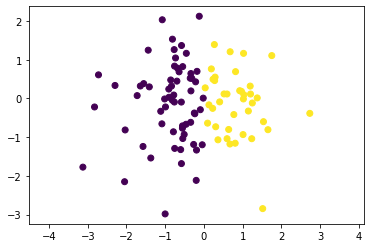

In [6]:
# Plot scatter data point
if PLOT:
    plt.scatter(x=x_train[:, 0], y=x_train[:, 1], c=np.squeeze(y_train))
    plt.axis('equal')
    plt.show()

# Build model

**We also can build another structures like change activation function, number of neural, number of layer, ...**

In [7]:
# Model
model = Sequential()
model.add(layer_name='input', n_unit=2, activation=None)
model.add(layer_name='dense', n_unit=3, activation='sigmoid')
model.add(layer_name='dense', n_unit=2, activation='tanh')
model.add(layer_name='output', n_unit=1, activation='sigmoid')

-> added layer 0_input_2_None
-> added layer 1_dense_3_sigmoid
-> added layer 2_dense_2_tanh
-> added layer 3_output_1_sigmoid


# Training model

In [8]:
# Training model
t1 = time.time()
loss = model.fit(x_train, y_train, epochs=EPOCHS, learning_rate=LEARNING_RATE)
t2 = time.time()
print("\nTime to train = ", t2 - t1)

100%|██████████| 10000/10000 [00:02<00:00, 4450.76it/s]


Time to train =  2.2527458667755127


# Plot loss history after each epochs

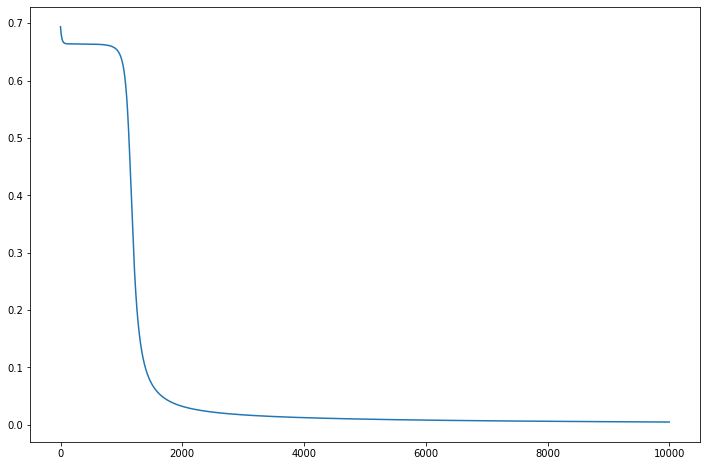

In [9]:
# Plot loss graph
if PLOT:
    plt.figure(figsize=(12, 8))
    plt.plot(range(EPOCHS), loss)
    plt.show()

### Predict and evaluate model using training set

In [10]:
 # Predict training set
t1 = time.time()
y_pred = model.predict(x_train)
t2 = time.time()
print("Time to test", t2 - t1)
accuracy = model.accuracy_score(y_train, y_pred)
print("Accuracy Train = ", accuracy)

Time to test 0.00032639503479003906
Accuracy Train =  1.0


### Create test set with another numpy random seed

In [11]:
np.random.seed(1998)
x, y = np.random.multivariate_normal(mean, cov, NUMBER_SAMPLES).T
x_test = np.concatenate((x.reshape(NUMBER_SAMPLES, 1), y.reshape(NUMBER_SAMPLES, 1)), axis=1)
y_test = np.where(x >= 0, 1.0, 0.0).reshape(NUMBER_SAMPLES, 1)

### Plot data of test set

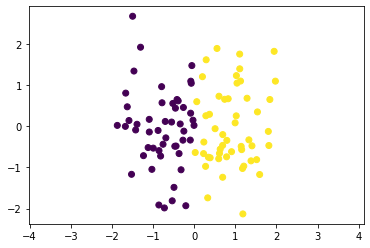

In [12]:
if PLOT:
    plt.scatter(x=x_test[:, 0], y=x_test[:, 1], c=np.squeeze(y_test))
    plt.axis('equal')
    plt.show()

### Predict and evaluate model using training set

In [13]:
# Predict test set
y_pred = model.predict(x_test)
accuracy = model.accuracy_score(y_test, y_pred)
print("Accuracy Test = ", accuracy)

Accuracy Test =  0.99


**Because we have very few in training set, so when you choose another seed, you should choose another hyper parameters like number epochs, learning rate, ... Or you can even change the neural network structure using "add" method or change the number of neural or activation function in this models**

